In [ ]:
# Making some essential imports as Usual
import os
import sys
import numpy as np
import re
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# defining function for dataLoading function
framObjTrain = {'img' : [],
           'mask' : []
          }

def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 128):
    imgNames = os.listdir(imgPath)
    maskNames = []

    ## generating mask names
    for mem in imgNames:
        mem = mem.split('_')[0]
        if mem not in maskNames:
            maskNames.append(mem)

    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'

    for i in range (len(imgNames)):
        try:
            img = plt.imread(imgAddr + maskNames[i] + '_sat.jpg')
            mask = plt.imread(maskAddr + maskNames[i] + '_mask.png')

        except:
            continue
        img = cv2.resize(img, (shape, shape))
        mask = cv2.resize(mask, (shape, shape))
        frameObj['img'].append(img)
        frameObj['mask'].append(mask[:,:,0]) # this is because its a binary mask and img is present in channel 0

    return frameObj

In [ ]:
# defining Conv2d block for our u-net
# this block essentially performs 2 convolution

def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)

    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)

    x =tf.keras.layers.Activation('relu')(x)

    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Activation('relu')(x)

    return x



# Now defining Unet
def Unet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)

    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)

    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)

    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)

    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)

    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)

    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)

    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)

    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)

    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model


In [ ]:
## instanctiating model
inputs = tf.keras.layers.Input((128, 128, 3))
unet = Unet(inputs, droupouts= 0.07)
unet.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

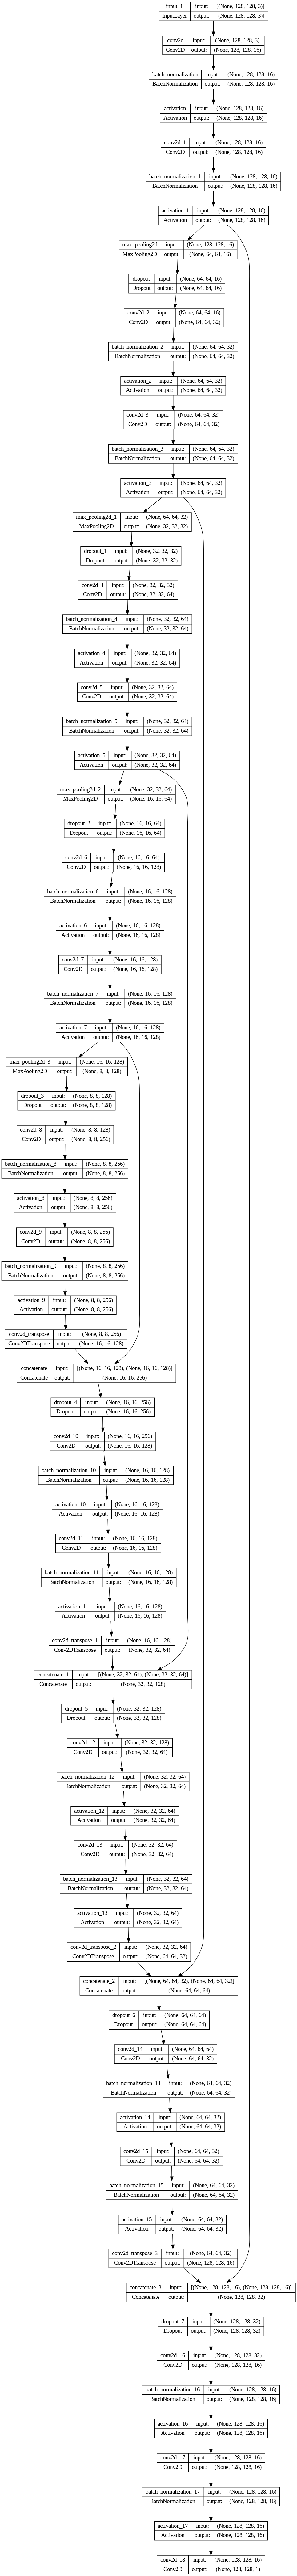

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(unet, to_file='UnetArchitecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
framObjTrain = LoadData( framObjTrain, imgPath = '/content/drive/MyDrive/T5_Python/road_extraction/train',
                        maskPath = '/content/drive/MyDrive/T5_Python/road_extraction/train'
                         , shape = 128)

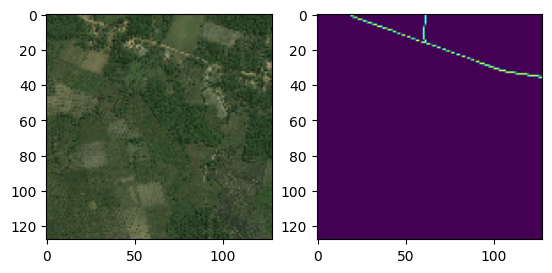

In [ ]:
## displaying data loaded by our function
plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][234])
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][234])
plt.show()

In [ ]:
retVal = unet.fit(np.array(framObjTrain['img']), np.array(framObjTrain['mask']), epochs = 40, verbose = 1)

Epoch 1/40
99/99 [==============================] - 32s 58ms/step - loss: 0.4545 - accuracy: 0.8663
Epoch 2/40
99/99 [==============================] - 5s 46ms/step - loss: 0.2418 - accuracy: 0.9532
Epoch 3/40
99/99 [==============================] - 5s 47ms/step - loss: 0.1892 - accuracy: 0.9533
Epoch 4/40
99/99 [==============================] - 5s 48ms/step - loss: 0.1669 - accuracy: 0.9533
Epoch 5/40
99/99 [==============================] - 5s 46ms/step - loss: 0.1561 - accuracy: 0.9533
Epoch 6/40
99/99 [==============================] - 5s 47ms/step - loss: 0.1491 - accuracy: 0.9533
Epoch 7/40
99/99 [==============================] - 5s 48ms/step - loss: 0.1431 - accuracy: 0.9533
Epoch 8/40
99/99 [==============================] - 5s 46ms/step - loss: 0.1383 - accuracy: 0.9533
Epoch 9/40
99/99 [==============================] - 5s 48ms/step - loss: 0.1332 - accuracy: 0.9533
Epoch 10/40
99/99 [==============================] - 5s 48ms/step - loss: 0.1284 - accuracy: 0.9536
Epoch 11

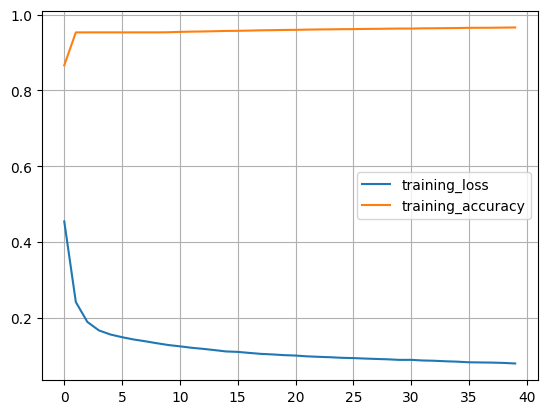

In [ ]:
plt.plot(retVal.history['loss'], label = 'training_loss')
plt.plot(retVal.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

In [ ]:
def predict (valMap, model, shape = 256):
    ## getting and proccessing val data
    img = valMap['img'][0:2000]
    mask = valMap['mask'][0:2000]
    #mask = mask[0:16]

    imgProc = img [0:2000]
    imgProc = np.array(img)

    predictions = model.predict(imgProc)


    return predictions, imgProc, mask


def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(9,9))

    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('Aerial image')

    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted Routes')

    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('Actual Routes')



In [ ]:
sixteenPrediction, actuals, masks = predict(framObjTrain, unet)

63/63 [==============================] - 1s 14ms/step


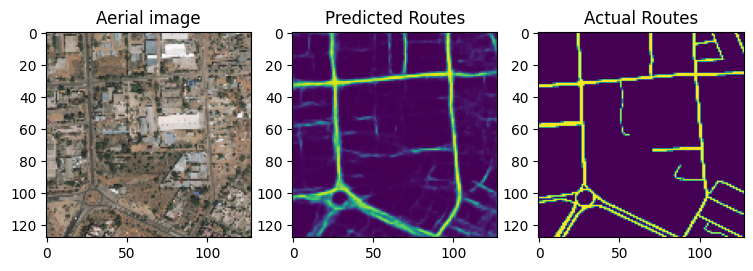

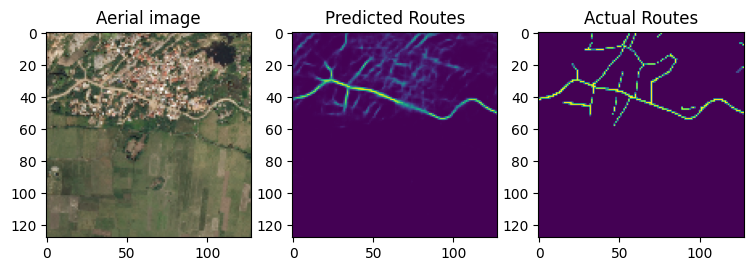

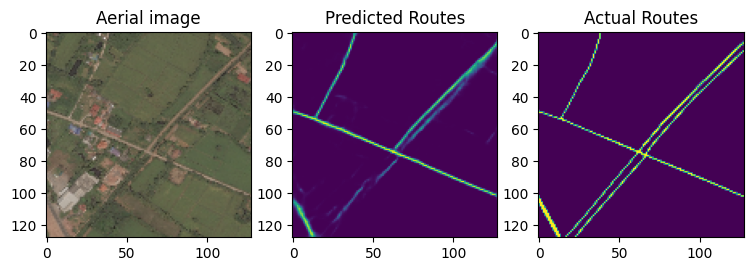

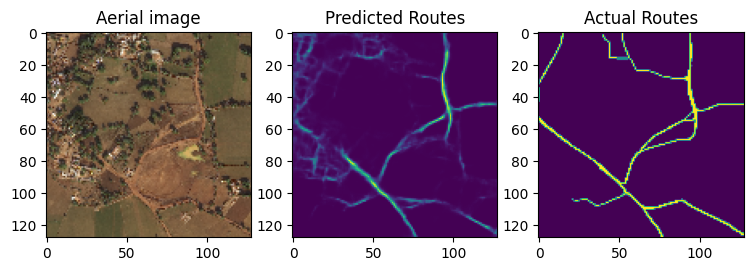

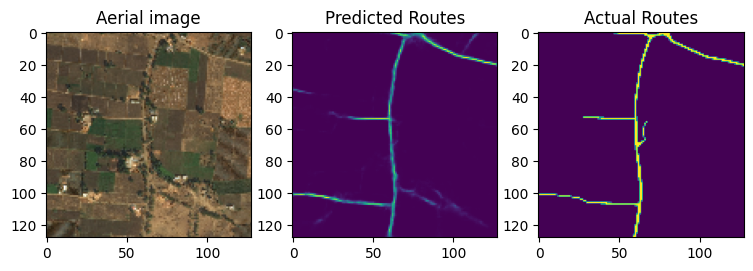

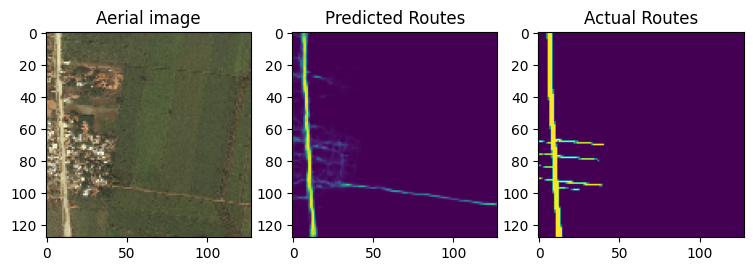

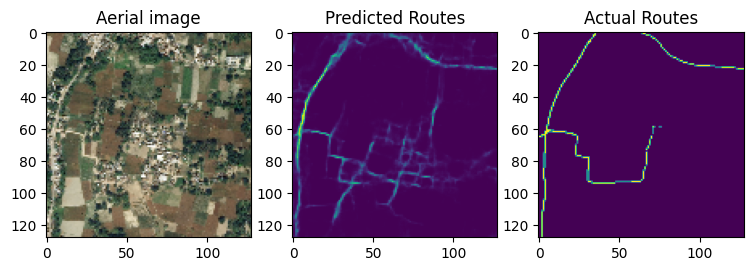

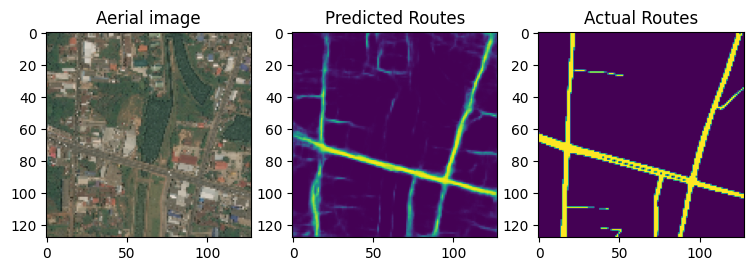

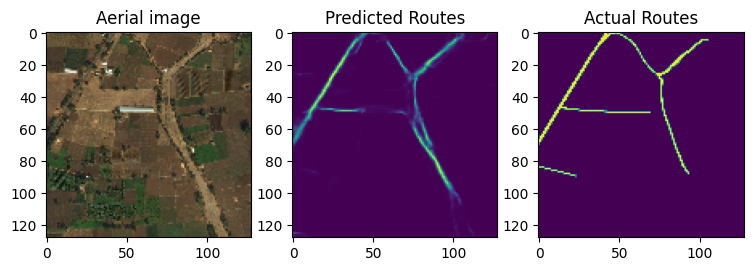

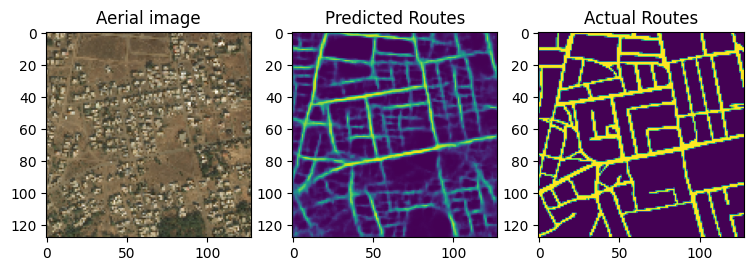

In [ ]:
import random

# Generate 10 random numbers between 1 and 9000
random_numbers = [random.randint(1, 2000) for _ in range(10)]

for i in random_numbers:
  Plotter(actuals[i], sixteenPrediction[i][:,:,0], masks[i])

In [ ]:
unet.save('RouteGenerator.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
'''
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
import numpy as np
import cv2

from keras.models import load_model

model = load_model('RouteGenerator.h5')

input_image = cv2.imread('')  # Replace 'your_image.jpg' with the path to your image

resized_image = cv2.resize(input_image, (128, 128))



predictions = model.predict(resized_image)


'''

"\nfrom keras.models import load_model\nfrom keras.preprocessing.image import load_img\nfrom keras.preprocessing.image import img_to_array\nfrom keras.applications.vgg16 import preprocess_input\nfrom keras.applications.vgg16 import decode_predictions\nfrom keras.applications.vgg16 import VGG16\nimport numpy as np\nimport cv2\n\nfrom keras.models import load_model\n\nmodel = load_model('RouteGenerator.h5')\n\ninput_image = cv2.imread('')  # Replace 'your_image.jpg' with the path to your image\n\nresized_image = cv2.resize(input_image, (128, 128))\n\n\n\npredictions = model.predict(resized_image)\n\n\n"

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.subplot(1, 3, 2)
plt.imshow(segment, cmap='virdis')
plt.title("Model Prediction")
